# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [177]:
# This is just to test if GPU is working
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17865320149032103830, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 25427968
 locality {
   bus_id: 1
 }
 incarnation: 11704640713473573178
 physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0"]

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [151]:
# All imports
import pickle
import random
import numpy as np
from itertools import groupby
import cv2
import os
from IPython import display
import time
import pylab as pl
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import csv
import operator
import copy
import matplotlib.image as mpimg

%matplotlib inline

In [187]:
training_file = "train.p"
testing_file = "test.p"

def load_dataset(file_name):
    dataset = pickle.load(open(file_name, "rb"))
    return (dataset["features"], dataset["labels"])

train = pickle.load(open(training_file, "rb"))
test = pickle.load(open(testing_file, "rb"))   
    
X_train, y_train = load_dataset(training_file)
X_test, y_test = load_dataset(testing_file)

In [188]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]

image_shape = np.array(X_test.shape[1:])

n_classes = len(list(groupby(sorted(y_train))))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 5052
Image data shape = [32 32  3]
Number of classes = 43


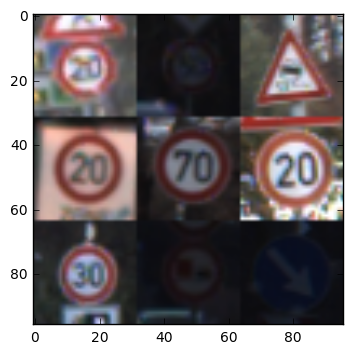

In [193]:
def show_img(img):
    shape = img.shape
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    elif img.ndim == 3:
        if shape[2] == 1:
            plt.imshow(img.reshape(shape[0], shape[1]), cmap='gray')
        elif shape[2] == 2:
            show_img(img[:,:,0])
            show_img(img[:,:,1])
        else:
            plt.imshow(img)
    plt.show()

column1 = np.concatenate([X_train[0], X_train[100], X_train[1500]], axis=0)
column2 = np.concatenate([X_train[4500], X_train[8000], X_train[15000]], axis=0)
column3 = np.concatenate([X_train[28000], X_train[50], X_train[38000]], axis=0)
show_img(np.concatenate([column1, column2, column3], axis=1))

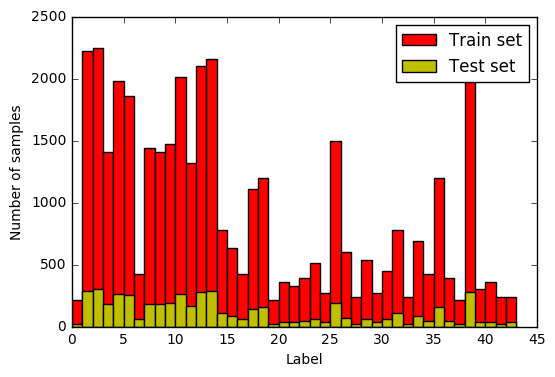

In [6]:
def build_labels_counts(labels):
    return list(zip(*map(lambda x: (x[0], len(list(x[1]))), groupby(sorted(labels)))))

trainset_counts = build_labels_counts(y_train)
testset_count = build_labels_counts(y_test)

width = 1

train_plot = plt.bar(trainset_counts[0], trainset_counts[1], width, label="Train set", color='r')
test_plot = plt.bar(testset_count[0], testset_count[1], width, label="Test set", color='y')

plt.legend(handles=[train_plot, test_plot])

plt.ylabel("Number of samples")
plt.xlabel("Label")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [146]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def convert_dataset(convert_fun, dataset):
    return list(map(convert_fun, dataset))

class Dataset:
    def __init__(self, train, validation, test):
        self.train = train
        self.validation = validation
        self.test = test

class DatasetProvider:
    __datasets = {}
    __converters = {}
    
    def __init__(self, original_train, original_valid, original_test):
        self.original_train = original_train
        self.original_valid = original_valid
        self.original_test = original_test
        
        self.register("original", lambda x: x)
    
    def register(self, name, conversion_function):
        train = convert_dataset(conversion_function, self.original_train)
        valid = convert_dataset(conversion_function, self.original_valid)
        test = convert_dataset(conversion_function, self.original_test)
        
        dataset = Dataset(train, valid, test)
        self.__converters[name] = conversion_function
        self.__datasets[name] = dataset     
        
    def get(self, name):
        return self.__datasets[name]
        
    def convert(self, name, data):
        converter = self.__converters[name]
        return convert_dataset(converter, data)
    
    def get_shape(self, name):
        return self.__datasets[name].train[0].shape
    
    def get_dataset_names(self):
        return self.__datasets.keys()
        

def to_onehot(label):
    result = np.zeros(n_classes, dtype=np.bool)
    result[label] = 1
    return result
    
def to_grayscale_eq(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    shape = gray.shape
    return cv2.equalizeHist(gray).reshape(shape[0], shape[1], 1)

def to_grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    shape = gray.shape
    return gray.reshape(shape[0], shape[1], 1)

def to_grayscale_norm_eq(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.equalizeHist(gray)
    gray = gray.astype(np.float32)
    gray = gray / 255.0
    shape = gray.shape
    return gray.reshape(shape[0], shape[1], 1)

def to_sharp_eq(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sharpen_kernel = np.array([[-1,-1,-1,-1,-1],
                             [-1,2,2,2,-1],
                             [-1,2,8,2,-1],
                             [-1,2,2,2,-1],
                             [-1,-1,-1,-1,-1]]) / 8.0
    gray = cv2.filter2D(gray, -1, sharpen_kernel)
    gray = cv2.equalizeHist(gray)
    
    shape = gray.shape
    return gray.reshape(shape[0], shape[1], 1)


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In my ML practice I usually follow the rule "If a trained human can solve some problem - ML algorithm _might_ solve it too. But if human can't - it is very unlikely that ML can do it". That's why I tried to make images better for me in the first place. So I tried:
- Converting image to grayscale
- Converting to grayscale and normalizing brightness/contrast it
- Converting image to HSV and normalizing brightness/contrast in V channel (not present in the above code)
- Converting image to grayscale and applying different 'sharpen' filters

However my experiments showed that resulting net works best on unprocessed dataset. It looks like net learns to adapt to different lighting conditions by itself. 

Well, that is not surprising. I can recognize most of the images in the original dataset. And that means that net _can_ do it as well.

In [7]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

def maybe_create_validation_set(validation_amount, donor_filename, result_filename):
    if os.path.isfile(validation_file):
        return
    
    print("Creating validation set")
    
    donor_set = pickle.load(open(donor_filename, "rb"))
    zipped = zip(donor_set['features'], donor_set['labels'])
    
    dictionary = {}
    
    for feature, label in zipped:
        dictionary.setdefault(label, []).append(feature)
        
    valid_zipped = []
    donor_zipped = []
    
    for label, features in dictionary.items():
        np.random.shuffle(features)
        split_point = int(len(features) * validation_amount)
        
        for feature in features[:split_point]:
            valid_zipped.append((label, feature))
        
        for feature in features[split_point:]:
            donor_zipped.append((label, feature))

    np.random.shuffle(valid_zipped)
    np.random.shuffle(donor_zipped)

    valid_labels, valid_features = zip(*valid_zipped)
    donor_labels, donor_features = zip(*donor_zipped)
    
    pickle.dump({'features': np.array(donor_features), 'labels': np.array(donor_labels)},
                open(donor_filename, "wb"))
    
    pickle.dump({'features': np.array(valid_features), 'labels': np.array(valid_labels)}, 
                open(result_filename, "wb"))


def randomly_translate_img(img):
    available_translations = [(-2, 0), (-1, -1), (0, -2), (1, 1), (0, 2), (2, 0)]
    choice = random.choice(available_translations)
    shape = img.shape
    M = np.float32([[1,0,choice[0]],[0,1,choice[1]]])
    return cv2.warpAffine(img, M, (shape[0],shape[1]))

def randomly_rotate_img(img):
    shape = img.shape
    angle = random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((shape[0]/2,shape[1]/2), angle, 1)
    return cv2.warpAffine(img, M, (shape[0],shape[1]))

def horizontal_blur_img(img):
    size = 3
    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur / size

    return cv2.filter2D(img, -1, kernel_motion_blur)

def jitter_feature(feature):
    effect = random.randint(0, 2)
    if effect == 0:
        return randomly_translate_img(feature)
    elif effect == 1:
        return randomly_rotate_img(feature)
    
    return horizontal_blur_img(feature)

def maybe_jitter_dataset(features, labels, result_filename):
    if os.path.isfile(result_filename):
        return
    
    features_result = []
    labels_result = []
    
    for i in range(len(features)):
        for j in range(5):
            features_result.append(jitter_feature(features[i]))
            labels_result.append(labels[i])
    
    pickle.dump({'features': np.array(features_result), 'labels': np.array(labels_result)},
                open(result_filename, "wb"))

In [10]:
jittered_file = "jit.p"
validation_file = "valid.p"

maybe_create_validation_set(0.6, testing_file, validation_file)
maybe_jitter_dataset(X_train, y_train, jittered_file)

X_train, y_train = load_dataset(jittered_file)
X_test, y_test = load_dataset(testing_file)
X_valid, y_valid = load_dataset(validation_file)

dataset_provider = DatasetProvider(X_train, X_valid, X_test)
dataset_provider.register("gray_eq", to_grayscale_eq)
dataset_provider.register("gray", to_grayscale)
dataset_provider.register("gray_norm_eq", to_grayscale_norm_eq)
dataset_provider.register("sharp_eq", to_sharp_eq)

y_train_onehot = convert_dataset(to_onehot, y_train)
y_valid_onehot = convert_dataset(to_onehot, y_valid)
y_test_onehot = convert_dataset(to_onehot, y_test)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

First I create validation set. To do that I simply split each class in provided test set into two parts with ratio 0.6. 

After that I jitter training set by adding 5 transformed images of each training sample.
I randomly choose one of three effects to apply:
- translate image by 1-2 pixels
- rotate image by [-15; 15] degrees
- or blur image horizontally

Additional data helps improve accuracy because:
- Some signs have very few images in dataset. More samples - better results
- Signs in real life not always installed straight. The more "deformations" net sees during training - the better it will handle such deformations later
- It actually helps reduce overfitting: net can't rely on exact position of some attributes. Instead it is forced to generalize

In [35]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Helper class, incapsulating neural net and it's parameters
# Such as tensorflow graph node, placeholders and other
class NetInstance:
    def __init__(self, tf_node, x_placeholder, name, dataset_name, variables, dropout_placeholder, y_placeholder):
        self.tf_node = tf_node
        self.x_placeholder = x_placeholder
        self.name = name
        self.dataset_name = dataset_name
        self.variables = variables
        self.dropout_placeholder = dropout_placeholder
        self.y_placeholder = y_placeholder

        
def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))


def create_biases(shape):
    return tf.Variable(tf.constant(0.1, shape = shape))


def conv2d(input_layer, filter_size, out_channels, stride=1, padding='SAME'):
    input_shape = input_layer.get_shape().as_list()
    
    weights_shape = [filter_size, filter_size, input_shape[3], out_channels]
       
    weights = create_weights(weights_shape)
    biases = create_biases([out_channels])
    
    output_layer = tf.nn.conv2d(input_layer, weights, [1, stride, stride, 1], padding)
    output_layer = tf.nn.bias_add(output_layer, biases)
    
    return (output_layer, weights, biases)


def max_pool(input_layer, size=2, padding='SAME'):
    dimensions = [1, size, size, 1]
    return tf.nn.max_pool(input_layer, dimensions, dimensions, padding)


def fully_connected(input_layer, output_nodes_number):
    input_shape = input_layer.get_shape().as_list()
    flat_size = np.prod(input_shape[1:]) 
    
    flat_input = tf.reshape(input_layer, [-1, flat_size])
    
    weights = create_weights([flat_size, output_nodes_number])
    biases = create_biases([output_nodes_number])
    
    result = tf.matmul(flat_input, weights)
    result = tf.nn.bias_add(result, biases)
    
    return (result, weights, biases) 


def chunks(input_list, chunk_size):
    return np.array([input_list[i:i+chunk_size] for i in range(0, len(input_list), chunk_size)])


def chunks2(list1, list2, chunk_size):
    return zip(chunks(list1, chunk_size), chunks(list2, chunk_size))


def create_batches(features, labels, batch_size):
    zipped = list(zip(features, labels))
    random.shuffle(zipped)
    unzipped = list(zip(*zipped))
    
    new_features = chunks(unzipped[0], batch_size)
    new_labels = chunks(unzipped[1], batch_size)
    
    return list(zip(new_features, new_labels))


def evaluate_net(net_instance, session, features, labels):      
    equal_fun = tf.equal(tf.argmax(net_instance.tf_node, 1), tf.argmax(net_instance.y_placeholder, 1))
    correct_num_func = tf.reduce_sum(tf.cast(equal_fun, tf.float32))
    correct_num = 0
          
    for features_chunk, labels_chunk in chunks2(features, labels, 100):
        correct_num += session.run(correct_num_func, feed_dict={
                net_instance.x_placeholder: features_chunk, 
                net_instance.y_placeholder: labels_chunk, 
                net_instance.dropout_placeholder: 1})
    
    return correct_num / len(features)


def create_ss_net(dataset_name, convolutions_shape, hidden_layers_shape):
    input_shape = [None, *dataset_provider.get_shape(dataset_name)]

    x_placeholder = tf.placeholder(tf.float32, input_shape)

    layer1, w1, b1 = conv2d(x_placeholder, 5, convolutions_shape[0])
    layer1 = max_pool(layer1)

    layer2, w2, b2 = conv2d(layer1, 5, convolutions_shape[1])
    layer2 = max_pool(layer2)

    variables = [w1, b1, w2, b2]
    last_layer = layer2
    for hidden_layer in hidden_layers_shape:
        last_layer, w, b = fully_connected(last_layer, hidden_layer)
        variables.append(w)
        variables.append(b)

    dropout_placeholder = tf.placeholder(tf.float32)
    last_layer = tf.nn.dropout(last_layer, dropout_placeholder)

    result, w, b = fully_connected(last_layer, n_classes)
    variables.append(w)
    variables.append(b)

    name = "SsNet: dataset={0}, convolutions={1}, hidden layers={2}".format(dataset_name, convolutions_shape, hidden_layers_shape)

    y_placeholder = tf.placeholder(tf.float32, [None, n_classes])
    
    return NetInstance(result, x_placeholder, name, dataset_name, variables, dropout_placeholder, y_placeholder)
   

def create_ms_net(dataset_name, convolutions_shape, hidden_layers_shape):
    input_shape = [None, *dataset_provider.get_shape(dataset_name)]

    x_placeholder = tf.placeholder(tf.float32, input_shape)

    layer1, w1, b1 = conv2d(x_placeholder, 5, convolutions_shape[0])
    layer1 = max_pool(layer1)

    layer2, w2, b2 = conv2d(layer1, 5, convolutions_shape[1])
    layer2 = max_pool(layer2)

    variables = [w1, b1, w2, b2]
    
    layer1_shape = layer1.get_shape().as_list()
    layer2_shape = layer2.get_shape().as_list()
        
    layer1_flat = tf.reshape(layer1, [-1, np.prod(layer1_shape[1:])])   
    layer2_flat = tf.reshape(layer2, [-1, np.prod(layer2_shape[1:])])
    
    last_layer = tf.concat(1, [layer1_flat, layer2_flat])
    for hidden_layer in hidden_layers_shape:
        last_layer, w, b = fully_connected(last_layer, hidden_layer)
        variables.append(w)
        variables.append(b)

    dropout_placeholder = tf.placeholder(tf.float32)
    last_layer = tf.nn.dropout(last_layer, dropout_placeholder)

    result, w, b = fully_connected(last_layer, n_classes)
    variables.append(w)
    variables.append(b)

    name = "MsNet: dataset={0}, convolutions={1}, hidden layers={2}".format(dataset_name, convolutions_shape, hidden_layers_shape)

    y_placeholder = tf.placeholder(tf.float32, [None, n_classes])
    
    return NetInstance(result, x_placeholder, name, dataset_name, variables, dropout_placeholder, y_placeholder)


class PlottingListener():
    def __init__(self, net_instance, session, dataset, epochs, grid_status, configuration_name):
        self.epochs = epochs
        self.session = session
        self.dataset = dataset
        self.net_instance = net_instance
        self.grid_status = grid_status
        self.configuration_name = configuration_name
        self.train_plot = []
        self.valid_plot = []
    
    def on_epoch(self, epoch):                   
        valid_accuracy = evaluate_net(self.net_instance, self.session, self.dataset.validation, y_valid_onehot)
        train_accuracy = evaluate_net(self.net_instance, self.session, self.dataset.train, y_train_onehot)
        
        display.clear_output(wait=True)
        print(self.grid_status)
        print(self.configuration_name)
        print("Epoch: {0}/{1}".format(epoch, self.epochs))
        print("  Validation accuracy:", valid_accuracy)
        print("  Train accuracy:", train_accuracy) 
        
        self.train_plot.append(train_accuracy)
        self.valid_plot.append(valid_accuracy)     
                
        plt.clf()
        plt.ylim(0,1)
        r, = plt.plot(self.valid_plot, 'r', label = "Validation accuracy")
        g, = plt.plot(self.train_plot, 'g', label = "Train accuracy")
        plt.legend(handles=[r,g], loc=4)
        display.display(pl.gcf())
                   
    
def train(net_instance, session, dataset, epochs, learning_rate, batch_size, dropout, listener):     
    learning_rate_placeholder = tf.placeholder(tf.float32)
    
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(net_instance.tf_node, net_instance.y_placeholder))
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate_placeholder).minimize(cross_entropy)

    # Global values should be initialized after Adam because it defines variables too
    session.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        if listener is not None:
            listener.on_epoch(epoch)
        batches = create_batches(dataset.train, y_train_onehot, batch_size)
        for features_batch, labels_batch in batches:        
            session.run(optimizer, feed_dict={
                net_instance.x_placeholder: features_batch, 
                net_instance.y_placeholder: labels_batch, 
                net_instance.dropout_placeholder: dropout, 
                learning_rate_placeholder: learning_rate
            })
    return evaluate_net(net_instance, session, dataset.validation, y_valid_onehot)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Final architecutre contains two convolution-max pool layers(100,100), connected to fully connected net with one hidden layer(1000 nodes). Both first and second convolution layer's results are fed to fully connected layer. It uses relu activations everywhere

In [143]:
### Train your model here.
### Feel free to use as many code cells as needed.

history = {}
history_file_name = "history.p"

if os.path.isfile(history_file_name):
    history = pickle.load(open(history_file_name, "rb"))
    
def save_history():
    pickle.dump(history, open(history_file_name, "wb"))

def mk_configuration_name(net_instance, learning_rate, dropout, epochs, batch_size):
    return "{0}, lr={1}, d={2}, e={3}, bs={4}".format(net_instance.name, learning_rate, dropout, epochs, batch_size) 

# Launches trainging and saves final accuracy to history
def maybe_train_and_save(net_instance, learning_rate, dropout, epochs, batch_size, grid_status, force = False):
    full_name = mk_configuration_name(net_instance, learning_rate, dropout, epochs, batch_size)
    if force == False and full_name in history:
        return
    
    print(grid_status)
    print(full_name)
    start_time = time.time()
    
    with tf.Session() as session:    
        dataset = dataset_provider.get(net_instance.dataset_name)
        listener = PlottingListener(net_instance, session, dataset, epochs, grid_status, full_name)
        
        validation_accuracy = train(net_instance, session, dataset, epochs, learning_rate, batch_size, dropout, listener)   
        prev_value = history.setdefault(full_name, 0)
        print("Validation accuracy =", validation_accuracy)
        if validation_accuracy > prev_value:
            history[full_name] = validation_accuracy
            save_history()  
            
    print("Elapsed: {0} seconds".format(int(time.time() - start_time)))
    print()
          
        
grid = [{}]  

def add_to_grid(name, values):
    global grid
    
    new_grid = []
    for node in grid:        
        for value in values:
            node_copy = copy.deepcopy(node)
            node_copy[name] = value
            new_grid.append(node_copy)
    
    grid = new_grid

add_to_grid("learning_rate", [1e-3, 1e-4])
add_to_grid("dropout", [0.1, 0.5])
add_to_grid("convolution_shape", [[100,100], [200, 200]])
add_to_grid("hidden_layers_shape", [[], [1000]])
add_to_grid("epochs", [10])
add_to_grid("batch_size", [50])
add_to_grid("dataset_name", dataset_provider.get_dataset_names())

grid_pos = 0
for node in grid:
    convolution_shape = node["convolution_shape"]
    hidden_layers_shape = node["hidden_layers_shape"]
    learning_rate = node["learning_rate"]
    dropout = node["dropout"]
    epochs = node["epochs"]
    batch_size = node["batch_size"]
    dataset_name = node["dataset_name"]
    
    grid_pos = grid_pos + 1
    grid_status = "Grid: {0}/{1}".format(grid_pos, 2 * len(grid))
    tf.reset_default_graph()
    ss_net = create_ss_net(dataset_name, convolution_shape, hidden_layers_shape)
    maybe_train_and_save(ss_net, learning_rate, dropout, epochs, batch_size, grid_status)
    
    grid_pos = grid_pos + 1
    grid_status = "Grid: {0}/{1}".format(grid_pos, 2 * len(grid))
    tf.reset_default_graph()
    ms_net = create_ms_net(dataset_name, convolution_shape, hidden_layers_shape)
    maybe_train_and_save(ms_net, learning_rate, dropout, epochs, batch_size, grid_status)

In [194]:
# For each grid node I write configuration name and best result it achieved
# Here you can see top10 networks with their results on validation set
sorted(history.items(), key=lambda x: x[1], reverse=True)[:10:]

[('MsNet: dataset=original, convolutions=[100, 100], hidden layers=[1000], lr=0.001, d=0.1, e=50, bs=50',
  0.97373977302718395),
 ('SsNet: dataset=gray, convolutions=[100, 100], hidden layers=[1000], lr=0.001, d=0.1, e=50, bs=50',
  0.97347585114806012),
 ('SsNet: dataset=gray, convolutions=[100, 100], hidden layers=[1000], lr=0.001, d=0.1, e=30, bs=50',
  0.97202428081287939),
 ('MsNet: dataset=original, convolutions=[100, 100], hidden layers=[1000], lr=0.001, d=0.1, e=30, bs=50',
  0.97083663235682238),
 ('SsNet: dataset=original, convolutions=[100, 100], hidden layers=[1000], lr=0.001, d=0.1, e=30, bs=50',
  0.970044866719451),
 ('MsNet: dataset=gray, convolutions=[100, 100], hidden layers=[1000], lr=0.001, d=0.1, e=30, bs=50',
  0.96846133544470836),
 ('MsNet: dataset=original, convolutions=[100, 100], hidden layers=[1000], lr=0.001, d=0.1, e=10, bs=50',
  0.96753760886777518),
 ('MsNet: dataset=gray_norm_eq, convolutions=[100, 100], hidden layers=[1000], lr=0.001, d=0.1, e=50, bs

In [149]:
# This is the final net with the best accuracy so far
session = tf.Session()

final_net = create_ms_net("original", [100, 100], [1000])
final_dataset = dataset_provider.get(final_net.dataset_name)
validation_accuracy = train(final_net, session, final_dataset, 30, 0.001, 50, 0.1, None)   
print("Final net: validation accuracy =", validation_accuracy)

test_accuracy = evaluate_net(final_net, session, final_dataset.test, y_test_onehot)
print("Final net: test accuracy =", test_accuracy)

Final net: validation accuracy = 0.966349960412
Final net: test accuracy = 0.970110847189


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used Adam optimizer. For me it worked million times better that gradient descend. 

For batch size, epochs and hyperparameters see Q5

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

To find optimal hyperparameters I used grid search.

But first, of course, I manually found some reasonable values for hyperparameters. Then I launched my grid and went skiing for a few days =)

I used grid to optimize:
- shape of convolution layers
- shape and amount of hidden layers
- ss or ms architecture
- best preprocessing algorithm
- learning rate
- batch size
- dropout

While doing grid search I set epochs to 10. To get results relatively fast. But for "production" net I set it to 30 to be sure that it squized maximum from training set.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [172]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

test_images = []
for img_name in os.listdir("test_images"):
    test_images.append(mpimg.imread("test_images/" + img_name))

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

10 km/h speed limit size was not present in training. And it looks very pale.

keep_right sign was captured from google street view. It is distorted and there is some google maps ui on top of it.

Other signs were captured from google street view as well. 

In [163]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

def get_signs_names():
    result = {}
    with open('signnames.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            classId = int(row['ClassId'])
            name = row['SignName']
            result[classId] = name
    return result
                    
sign_names = get_signs_names()

def show_what_net_thinks(sample, net):
    top5 = session.run(tf.nn.top_k(tf.nn.softmax(net.tf_node), k=5),
                       feed_dict={net.x_placeholder: [sample], net.dropout_placeholder: 1})

    indices = top5.indices[0]
    values = top5.values[0]
    
    for i in range(len(indices)):
        index = indices[i]
        p = values[i]
        print("{0} {1:.3f}".format(sign_names[index], p))

    show_img(sample)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**

Yes, model does very good job. Except for sign it never saw.


Road work 1.000
Speed limit (20km/h) 0.000
Speed limit (30km/h) 0.000
Speed limit (50km/h) 0.000
Speed limit (60km/h) 0.000


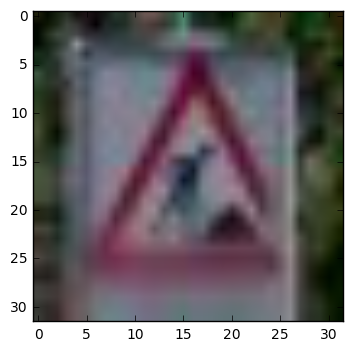

Keep right 1.000
Speed limit (20km/h) 0.000
Speed limit (30km/h) 0.000
Speed limit (50km/h) 0.000
Speed limit (60km/h) 0.000


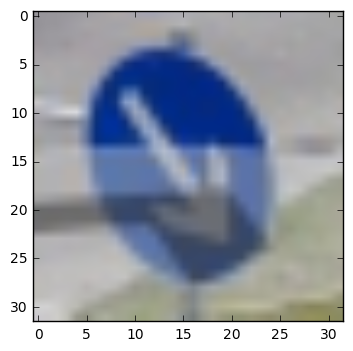

Speed limit (100km/h) 1.000
Speed limit (20km/h) 0.000
Speed limit (30km/h) 0.000
Speed limit (50km/h) 0.000
Speed limit (60km/h) 0.000


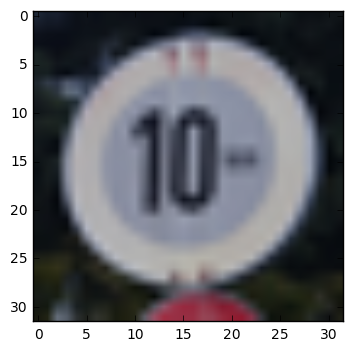

No entry 1.000
Speed limit (20km/h) 0.000
Speed limit (30km/h) 0.000
Speed limit (50km/h) 0.000
Speed limit (60km/h) 0.000


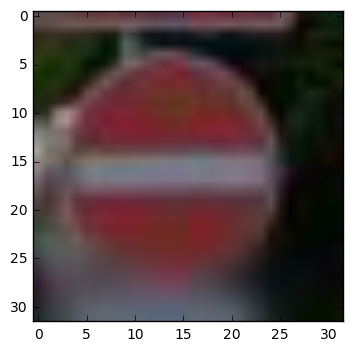

Speed limit (80km/h) 1.000
Speed limit (20km/h) 0.000
Speed limit (30km/h) 0.000
Speed limit (50km/h) 0.000
Speed limit (60km/h) 0.000


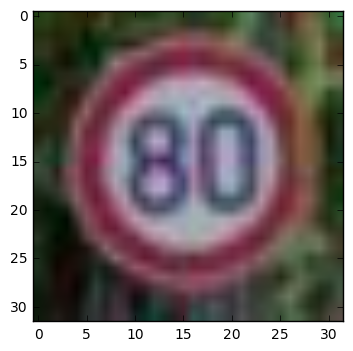

In [176]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

for img in test_images[:5]:
    show_what_net_thinks(img, final_net)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

In all tests confidence of model is 100%. 
I am not sure if it is a good sign - it looks overconfident.
But it gives very low percent of errors anyway


### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.